<a href="https://colab.research.google.com/github/saugabriele/Machine_Learning_Project/blob/main/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Malicious Url Detector Project**
To develop a classifier for detecting malicious URLs, the project started with a dataset containing a few URLs. In this case I tried to create a multiclass classifier that can classify a URL like:
- **Benign**: These are safe to browse URLs.
- **Phishing**: By creating phishing URLs, hackers try to steal sensitive personal or financial information such as login credentials
- **Malware**:These type of URLs inject malware into the victim’s system once he/she visit such URLs.
- **Defacement**: Defacement URLs are generally created by hackers with the intention of breaking into a web server and replacing the hosted website with one of their own

In [ ]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [ ]:
#Create a DataFrame from the dataset csv file
df = pd.read_csv("https://raw.githubusercontent.com/saugabriele/Machine_Learning_Project/main/malicious_phish1.csv")
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
#Convert the DataFrame in numpy arrays
url_array = df['url'].to_numpy()
type_array = df['type'].to_numpy()

##**Features Extraction**
To determine the class label of an URL, the first step was selecting the features that can be extracted from an URL. In this case i decided to extract some lexical features:
- These refer to statistical features extracted from the literal URL string. For example, length of the URL string, number of digits, number of parameters in its query part, if the URL is encoded, etc.

In [ ]:
def www_count(url):
  """
    From the input URL this will return the number of 
    occurrences of the substring 'www'.
  """
  return url.count('www')

def at_count(url):
  """
    From the input URL this will return the number of 
    occurrences of the substring '@'.
  """
  return url.count('@')

def url_lenght(url):
  """
    From the input URL this will return the
    corresponding length
  """
  return len(url)

def url_path_len(url):
  """
    From the input URL this will return the length
    of the path where the resource is located.
  """
  url_parse = urlparse(url)
  return len(url_parse.path)

def host_len(url):
  """
     From the input URL this will return the length
     of the hostname.
  """
  url_parse = urlparse(url)
  return len(url_parse.netloc)

def url_host_is_ip(url):
  """
    From the input URL this will return 1 if the hostname
    contains the IP adress otherwise it returns 0 if it
    contains the domain name where the resource is located.
  """
  url = urlparse(url)
  reg = r"^(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.){3}([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])$"
  if re.match(reg, url.netloc):
      return 1
  else:
      return 0

def number_of_digits(url):
  """
    From the input URL this will return the number of 
    digits in the URL.
  """
  digits = [i for i in url if i.isdigit()]
  return len(digits)

def number_of_parameters(url):
  """
    From the input URL this will return the number of
    parameters contained in the URL.
  """
  params = urlparse(url).query
  return 0 if params == '' else len(params.split('&'))

def number_of_subdirectories(url):
  """
    From the input URL this will return the number of
    subdirectories in the path of the URL.
  """
  d = urlparse(url).path.split('/')
  return len(d) - 1

def number_of_periods(url):
  """
    From the input URL this will return the number of
    periods in the URL.
  """
  return url.count('.')

def num_encoded_char(url):
  """
    From the input URL this will return the number of
    encoded characters in the URL.
  """
  return url.count('%')

def equal_count(url):
  """
    From the input URL this will return the number of
    variable values passed from one form page to another.
  """
  return url.count('=')

def count_http(url):
  """
    From the input URL this will return the number of 
    occurrences of the substring 'http'.
  """
  return url.count('http')

def count_https(url):
  """
    From the input URL this will return the number of 
    occurrences of the substring 'https'.
  """
  return url.count('https')

features_extraction_func = []
features_extraction_func.append(np.vectorize(www_count))
features_extraction_func.append(np.vectorize(at_count))
features_extraction_func.append(np.vectorize(url_lenght))
features_extraction_func.append(np.vectorize(url_path_len))
features_extraction_func.append(np.vectorize(host_len))
features_extraction_func.append(np.vectorize(url_host_is_ip))
features_extraction_func.append(np.vectorize(number_of_digits))
features_extraction_func.append(np.vectorize(number_of_parameters))
features_extraction_func.append(np.vectorize(number_of_subdirectories))
features_extraction_func.append(np.vectorize(number_of_periods))
features_extraction_func.append(np.vectorize(num_encoded_char))
features_extraction_func.append(np.vectorize(equal_count))
features_extraction_func.append(np.vectorize(count_http))
features_extraction_func.append(np.vectorize(count_https))

In [ ]:
def make_predictor_variables(features_extraction_func, urls):
  """
    From the URLs contained in the dataset this returns all
    the extracted features as a numpy array of
    shape = (number of URLs, number of features).
  """
  x = np.zeros(shape = (url_array.shape[0], len(features_extraction_func)))

  for i, function in enumerate(features_extraction_func):
    x[:, i] = function(urls)

  return x

x = make_predictor_variables(features_extraction_func, url_array)

##**Features discriminant capability evaluation**
Now I made an analysis on the features discriminant capacibility, where i check the distribution of the features for all the classes. We the following four example we can see that:
- On average, the number of @ in the url is very high for phishing URLs and low for the others expecially for defacement URLs.
- On average, the url length is almost the same for all classes, a bit higher for defacement URLs.
- On average, the URL length is higher for benign URLs and lower for other classes.
- On average, the hostname path is very high for defacement  URLs and a bit smaller for malware URLs and lower for other classes expecially for benign URLs

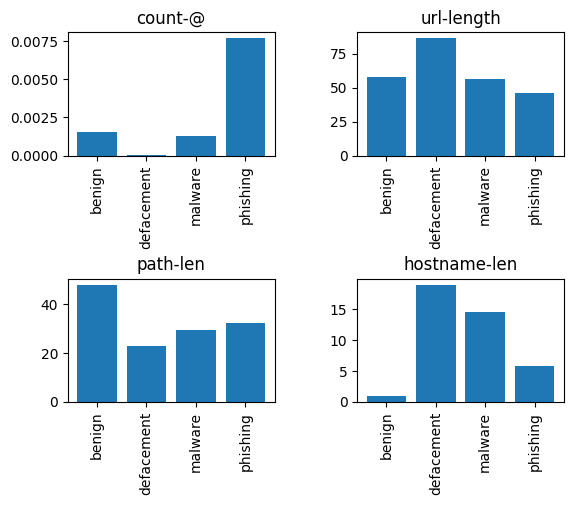

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=0.4)

plot_titles = ["count-@", "url-length", "path-len", "hostname-len"]
x_labels = np.unique(type_array)
height_plot = np.zeros(shape = (len(plot_titles), len(x_labels)))
x_plot = np.arange(1,5)

for j in range(len(plot_titles)):
  for i, label in enumerate(x_labels):
    height_plot[j][i] = x[type_array == label, j+1].mean()

for i in range(len(plot_titles)):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(plot_titles[i])
    ax.set_xticks(x_plot)
    ax.set_xticklabels(x_labels, rotation = 90)
    ax.bar(x_plot, height_plot[i])

##**Preprocessing and Train&Test Split**

In [ ]:
# Encoding of the target labels with value between 0 and n_classes-1
label_encoder =LabelEncoder()
Y = label_encoder.fit_transform(type_array)

# Define the scaler
scaler = MinMaxScaler()

# Train and test split
splitter = ShuffleSplit(n_splits=10, test_size=0.5)

In [ ]:
def run(x, y, splitter, scaler, clf):
    """Take input data (x,y), split it (n times), scale it, 
    learn classifier on training data, and evaluate the mean test error.
    """
    acc = np.zeros(shape=(splitter.get_n_splits(),))

    for i, (tr_idx, ts_idx) in enumerate(splitter.split(x, y)):
        xtr = x[tr_idx, :]
        ytr = y[tr_idx]
        xts = x[ts_idx, :]
        yts = y[ts_idx]

        xtr = scaler.fit_transform(xtr)
        xts = scaler.transform(xts)

        clf.fit(xtr, ytr)
        ypred = clf.predict(xts)
        acc[i] = (ypred == yts).mean()    
    return acc

##**Models Building**

###**Nearest Centroid Classifier**

In [ ]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()

acc = run(x, Y, splitter, scaler, clf)
print("Mean test accuracy: {:.1%} +/- {:.1%}".format(acc.mean(), 2*acc.std()))
print("Mean test error: {:.1%} +/- {:.1%}".format(1-acc.mean(), 2*acc.std()))

Mean test accuracy: 79.7% +/- 5.3%
Mean test error: 20.3% +/- 5.3%


###**Gaussian Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB() 

acc = run(x, Y, splitter, scaler, clf)
print("Mean test accuracy: {:.1%} +/- {:.1%}".format(acc.mean(), 2*acc.std()))
print("Mean test error: {:.1%} +/- {:.1%}".format(1-acc.mean(), 2*acc.std()))

Mean test accuracy: 78.3% +/- 0.1%
Mean test error: 21.7% +/- 0.1%


###**Random Forest Classifier**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = GridSearchCV(estimator= RandomForestClassifier(), param_grid={'n_estimators': [5, 10, 15]}) 

acc = run(x, Y, splitter, scaler, clf)

print("Parameters Estimation")
print("Best parameters set found on training set:", clf.best_params_)
print("Grid scores on training set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("        %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print("Mean test accuracy: {:.1%} +/- {:.1%}".format(acc.mean(), 2*acc.std()))
print("Mean test error: {:.1%} +/- {:.1%}".format(1-acc.mean(), 2*acc.std()))

Parameters Estimation
Best parameters set found on training set: {'n_estimators': 15}
Grid scores on training set:
        0.953 (+/-0.002) for {'n_estimators': 5}
        0.955 (+/-0.002) for {'n_estimators': 10}
        0.955 (+/-0.002) for {'n_estimators': 15}
Mean test accuracy: 95.6% +/- 0.1%
Mean test error: 4.4% +/- 0.1%


###**K Nearest Neighbours classifiers**

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

clf = KNeighborsClassifier()

x_train, x_test, y_train, y_test = train_test_split(x, Y, train_size = 0.5, test_size= 0.5)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

clf.fit(x_train, y_train)
y_pred  = clf.predict(x_test)
acc = (y_pred == y_test).mean()
print("Test accuracy: {:.1%}".format(acc))
print("Test error: {:.1%}".format(1-acc))

Test accuracy: 95.0%
Test error: 5.0%
